<a href="https://colab.research.google.com/gist/pouyahosseinzadeh/c088598efbf1aae0bf3604ce3f9ac422/streamflow-prediction-in-the-ucrb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streamflow Prediction in the UCRB

# Univariate Time-series Models

# RFR

In [ ]:
# import
import pandas as pd
import numpy as np
import datetime

import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from pandas import read_csv
import warnings
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')


In [ ]:
# For changing the sclae to mm
b = 4.20184e-6

In [ ]:
# train and test datasets, preprocessing

my_dataset1 = read_csv("/content/train-validation.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')


my_dataset_df = my_dataset1.copy()
my_dataset_df = my_dataset_df.reset_index()



data = my_dataset_df['discharges']

# FOR TRAINING..
def create_dataset(dataset, look_back, look_ahead):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-look_back-look_ahead): 
        a = dataset[i:i + look_back]   
        dataX.append(a)
        b = dataset[i + look_back: i+look_back+look_ahead]  
        dataY.append(b)
    return dataX, dataY


# hyperparameters
look_back_size = 24
look_ahead_size = 24

x_train, y_train = create_dataset(data, look_back_size, look_ahead_size) 


x_train = np.array(x_train)
y_train = np.array(y_train)


my_dataset2 = read_csv("/content/test.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')




my_dataset_df2 = my_dataset2.copy()
my_dataset_df2 = my_dataset_df2.reset_index()



In [ ]:
# training phase and forecast

model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=10, min_samples_leaf=5, max_depth=9, bootstrap=True)
model.fit(x_train, y_train)


data_test = my_dataset_df2['discharges']


forecast_all = []
real_values = []

for i in range(len(data_test)-look_back_size-look_ahead_size):
  x_test = data_test[i:i+look_back_size]

  y_test = data_test[i+look_back_size:i+look_back_size+look_ahead_size]
  real_values.append(y_test)

  x_test = np.array(x_test)
  x_test = x_test.reshape(-1, look_back_size)
  forecast = model.predict(x_test)
  forecast_all.append(forecast[0])



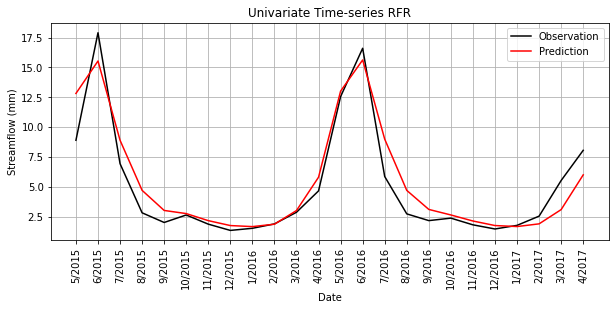

In [ ]:
# Visualization

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(real_values[29].values * b, color = 'black', label = 'Observation')
plt.plot(forecast_all[29] * b, color = 'red', label = 'Prediction')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['5/2015', "6/2015", "7/2015", "8/2015", "9/2015", "10/2015", "11/2015", "12/2015", "1/2016", "2/2016", "3/2016", "4/2016", "5/2016", "6/2016", "7/2016", "8/2016", "9/2016", "10/2016", "11/2016", "12/2016", "1/2017", "2/2017", "3/2017", "4/2017"], rotation=90)
plt.title('Univariate Time-series RFR')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.grid()
plt.legend()
plt.show()



# LSTM

In [ ]:
# import


import random
random.seed(0)

from sklearn.preprocessing import StandardScaler

import tensorflow


tensorflow.random.set_seed(0)

import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import read_csv


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation

In [ ]:

# load dataset and preprocessing

my_dataset1 = read_csv("/content/train-validation_.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')




my_dataset_df = my_dataset1.copy()
my_dataset_df = my_dataset_df.reset_index()



data = my_dataset_df[['discharges']]





scaler1 = StandardScaler()
data = data.to_numpy()
scaler1.fit(data)
data = scaler1.transform(data)



# load dataset
my_dataset2 = read_csv("/content/test_.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')




my_dataset_df2 = my_dataset2.copy()
my_dataset_df2 = my_dataset_df2.reset_index()




data_test = my_dataset_df2[['discharges']]


# we will add features here in Phase2
data_test['discharges_real'] = data_test['discharges']


# we will get all features here in Phase2
data_test1 = data_test.iloc[:, [0]]


# we are only interested in the discharges. In both phases
data_test2 = data_test.iloc[:, [1]]





data_test = data_test.to_numpy()
data_test1 = scaler1.transform(data_test1)



def split_my_dataset(my_dataset, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(my_dataset)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(my_dataset):
      break
    past, future = my_dataset[window_start:past_end, :], my_dataset[past_end:future_end, 0]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)


# hyperparameters
n_past = 72
n_future = 24
n_features = 1



x_train, y_train = split_my_dataset(data,n_past, n_future)


x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))


In [ ]:
# training phase and forecast

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_past, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_future))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


history = model.fit(x_train, y_train, epochs=12, batch_size=8, verbose=0, validation_split=0.3, shuffle=True)


my_model = model



forecast_all = []
real_values = []

for i in range(len(data_test)-n_past-n_future):
  x_test = data_test1[i:i+n_past, :]

  y_test = data_test2[i+n_past:i+n_past+n_future]
  real_values.append(y_test)

  x_test = np.array(x_test)
  x_test = x_test.reshape(1, n_past, n_features)
  forecast = my_model.predict(x_test)
  forecast = forecast.reshape(-1, 1)
  forecast = scaler1.inverse_transform(forecast)
  forecast_all.append(forecast)


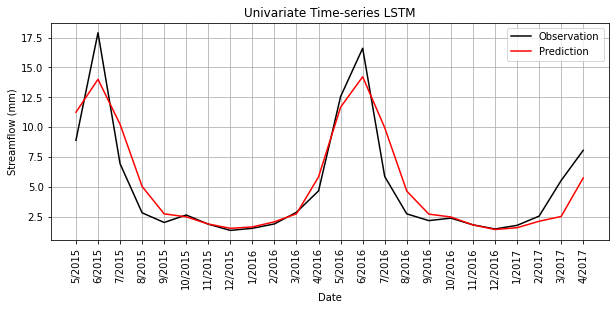

In [ ]:
# Visualization


plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(real_values[29].values * b, color = 'black', label = 'Observation')
plt.plot(forecast_all[29] * b, color = 'red', label = 'Prediction')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['5/2015', "6/2015", "7/2015", "8/2015", "9/2015", "10/2015", "11/2015", "12/2015", "1/2016", "2/2016", "3/2016", "4/2016", "5/2016", "6/2016", "7/2016", "8/2016", "9/2016", "10/2016", "11/2016", "12/2016", "1/2017", "2/2017", "3/2017", "4/2017"], rotation=90)
plt.title('Univariate Time-series LSTM')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.grid()
plt.legend()
plt.show()



# SARIMA

In [ ]:
# import

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas import read_csv



In [ ]:
# load dataset


my_dataset = read_csv("/content/DATA.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')



data = my_dataset['discharges']



In [ ]:
# training phase and forecast

import statsmodels.api as sm

def arimaTrain(train_data):

  # hyperparameters
  model=sm.tsa.statespace.SARIMAX(train_data,order=(3, 0, 2), seasonal_order=(2,0,1,12))  
  fitted = model.fit(disp=-1)
  # print(fitted.summary())
  return fitted




forecast_all = []
real_all = []

for i in range(0, 50):

  # these parameters are set to divide training and testing datasets
  x_train = data[i:i+1260+24] 

  starting = 1260+24
  ending = 1260+24+24-1

  y_test = data[i+1260+24:i+1260+24+24]
  # print(y_test)
  real_all.append(y_test)

  fitted_value = arimaTrain(x_train)
  forecast = fitted_value.predict(start=starting,end=ending,dynamic=True)

  forecast_all.append(forecast)



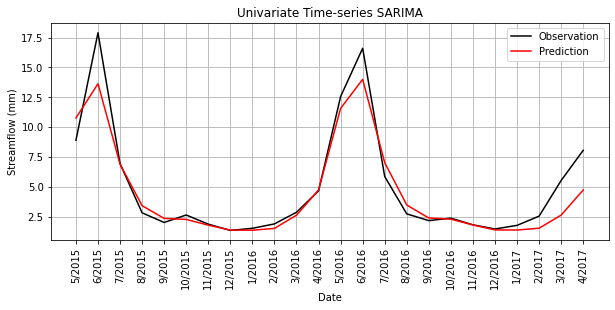

In [ ]:
real_values = real_all
# print(real_values[0].values)


plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(real_values[29].values * b, color = 'black', label = 'Observation')
plt.plot(forecast_all[29].values * b, color = 'red', label = 'Prediction')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['5/2015', "6/2015", "7/2015", "8/2015", "9/2015", "10/2015", "11/2015", "12/2015", "1/2016", "2/2016", "3/2016", "4/2016", "5/2016", "6/2016", "7/2016", "8/2016", "9/2016", "10/2016", "11/2016", "12/2016", "1/2017", "2/2017", "3/2017", "4/2017"], rotation=90)
plt.title('Univariate Time-series SARIMA')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.grid()
plt.legend()
plt.show()

# PROPHET

In [ ]:
# !pip install Prophet

In [ ]:
# import

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import read_csv
from prophet import Prophet


# to remove warnings in output
import logging
logging.getLogger("prophet").propagate=False

In [ ]:
# load dataset and forecast

my_dataset = read_csv("/content/DATA2P.txt", sep="\t", header=None, names = ['ds', 'y'], thousands=',')



df = my_dataset
df = df[['ds', 'y']]


In [ ]:
# training phase and forecast

forecast_all = []
real_all = []

for i in range(0, 120):

    x_train = df[i:i + 1190 + 24]

    y_test = df[i + 1190 + 24:i + 1190 + 24 + 24]
    real_all.append(y_test)

    m = Prophet

    m = Prophet(changepoint_prior_scale=0.1,
                          n_changepoints=150,
                          seasonality_mode='multiplicative',
                          weekly_seasonality=True,
                          # daily_seasonality=True,
                          yearly_seasonality=True,
                          interval_width=0.95)


    m.fit(x_train)
    future = m.make_future_dataframe(periods=24, freq='M')

    forecast = m.predict(future)
    yhat_test = forecast['yhat'][-24:]
    yhat_test = np.array(yhat_test)
    forecast_all.append(yhat_test)



# print(forecast_all[0])


real_values = real_all
# print(real_values[0]['y'].values)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8n68k3ez/0z7kz7oo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8n68k3ez/leavxmqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29405', 'data', 'file=/tmp/tmp8n68k3ez/0z7kz7oo.json', 'init=/tmp/tmp8n68k3ez/leavxmqv.json', 'output', 'file=/tmp/tmpcpzvjrsf/prophet_model-20220911175915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8n68k3ez/4skcznki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8n68k3ez/6bnlz7dh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

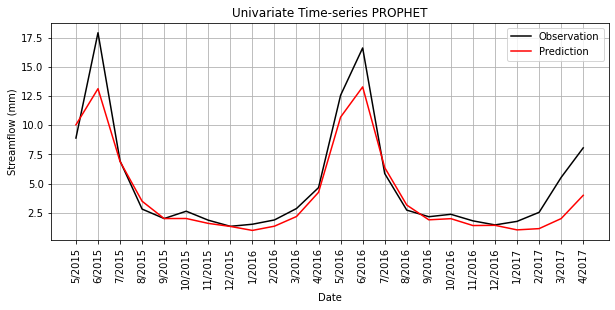

In [ ]:

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(real_values[99]['y'].values * b, color = 'black', label = 'Observation')
plt.plot(forecast_all[99] * b, color = 'red', label = 'Prediction')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['5/2015', "6/2015", "7/2015", "8/2015", "9/2015", "10/2015", "11/2015", "12/2015", "1/2016", "2/2016", "3/2016", "4/2016", "5/2016", "6/2016", "7/2016", "8/2016", "9/2016", "10/2016", "11/2016", "12/2016", "1/2017", "2/2017", "3/2017", "4/2017"], rotation=90)
plt.title('Univariate Time-series PROPHET')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.grid()
plt.legend()
plt.show()

# --------------------

# Multivariate Time-series Models

# RFR

In [ ]:
# load dataset
series_temp = read_csv("/content/Step2_TEMPERATURES.csv")

series_temp = series_temp['Temperature']


series_temp = series_temp.values

# For the train-test data division
series_temp1 = series_temp[0:1260]    
series_temp1

series_temp2 = series_temp[1260:1260+98+45]



# load dataset
series_ppt = read_csv("/content/Step2_PRECIPITATIONS.csv")

series_ppt = series_ppt['Precipitation']

series_ppt = series_ppt.values


series_ppt1 = series_ppt[0:1260]


series_ppt2 = series_ppt[1260:1260+98+45]







# load dataset

series1 = read_csv("/content/train-validation.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')




series1['temperatures'] = series_temp1
series1['precipitation'] = series_ppt1





series_df = series1.copy()
series_df = series_df.reset_index()


data = series_df[['discharges', 'temperatures', 'precipitation']]
data


# THE SAME AS LSTM MODEL INPUT.. FOR TRAINING..
def create_dataset(dataset, look_back, look_ahead):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-look_back-look_ahead): 
        a = dataset[i:i + look_back]   
        dataX.append(a)
        b = dataset['discharges'][i + look_back: i+look_back+look_ahead]  
        dataY.append(b)
    return dataX, dataY


# hyperparameters
look_back = 24
look_ahead = 24
x_train, y_train = create_dataset(data, look_back, look_ahead) 



x_train = np.array(x_train)
x_train = x_train.reshape(-1, look_back*3)
y_train = np.array(y_train)


series2 = read_csv("/content/test.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')



series2['temperatures'] = series_temp2
series2['precipitation'] = series_ppt2





series_df2 = series2.copy()
series_df2 = series_df2.reset_index()



data_test = series_df2[['discharges', 'temperatures', 'precipitation']]


In [ ]:
# Training and testing Phase

model = RandomForestRegressor(n_estimators=1000, random_state=2, min_samples_split=2, min_samples_leaf=1, max_depth=4, bootstrap=True)
model.fit(x_train, y_train)



forecast_all = []
real_values = []

for i in range(len(data_test)-look_back-look_ahead):
  x_test = data_test[i:i+look_back]

  y_test = data_test['discharges'][i+look_back:i+look_back+look_ahead]
  real_values.append(y_test)

  x_test = np.array(x_test)
  x_test = x_test.reshape(-1, look_back*3)       # 24*3 = 72
  forecast = model.predict(x_test)
  forecast_all.append(forecast[0])


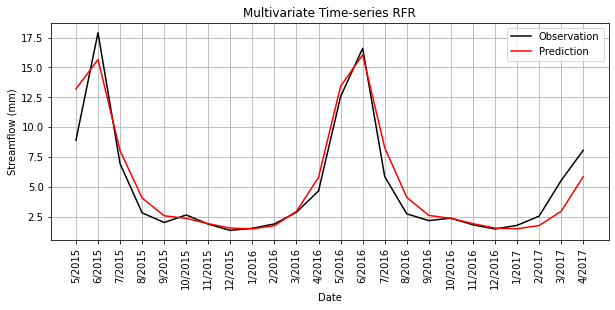

In [ ]:
# Visualization


plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(real_values[29].values * b, color = 'black', label = 'Observation')
plt.plot(forecast_all[29] * b, color = 'red', label = 'Prediction')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['5/2015', "6/2015", "7/2015", "8/2015", "9/2015", "10/2015", "11/2015", "12/2015", "1/2016", "2/2016", "3/2016", "4/2016", "5/2016", "6/2016", "7/2016", "8/2016", "9/2016", "10/2016", "11/2016", "12/2016", "1/2017", "2/2017", "3/2017", "4/2017"], rotation=90)
plt.title('Multivariate Time-series RFR')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.grid()
plt.legend()
plt.show()



# LSTM

In [ ]:
# import


import random
random.seed(0)

from sklearn.preprocessing import StandardScaler

import tensorflow


tensorflow.random.set_seed(0)

import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# from matplotlib import style
from sklearn import metrics
from pandas import read_csv
from sklearn.metrics import mean_squared_error


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation

In [ ]:


# load dataset
series_temp = read_csv("/content/Step2_TEMPERATURES.csv")

series_temp = series_temp['Temperature']


series_temp = series_temp.values


series_temp1 = series_temp[0:1260]   

# To meet the 72-month input data
series_temp2 = series_temp[1260-12-12-12-12:1260+98]



# load dataset
series_ppt = read_csv("/content/Step2_PRECIPITATIONS.csv")

series_ppt = series_ppt['Precipitation']

series_ppt = series_ppt.values

# To meet the 72-month input data
series_ppt1 = series_ppt[0:1260]


series_ppt2 = series_ppt[1260-12-12-12-12:1260+98]   








# load dataset

series1 = read_csv("/content/train-validation_.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')



series1['temperatures'] = series_temp1
series1['precipitation'] = series_ppt1




series_df = series1.copy()
series_df = series_df.reset_index()


data = series_df[['discharges', 'temperatures', 'precipitation']]

data2 = series_df[['discharges']]


from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
data = data.to_numpy()
scaler1.fit(data)
data = scaler1.transform(data)


from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()
data2 = data2.to_numpy()
scaler2.fit(data2)
data2 = scaler2.transform(data2)


# load dataset

series2 = read_csv("/content/test_.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')


series2['temperatures'] = series_temp2
series2['precipitation'] = series_ppt2


series_df2 = series2.copy()
series_df2 = series_df2.reset_index()
series_df2


data_test = series_df2[['discharges', 'temperatures', 'precipitation']]

# we will add features here in Phase2
data_test['discharges_real'] = data_test['discharges']


# we will get all features here in Phase2
data_test1 = data_test.iloc[:, [0, 1, 2]]
data_test1

# we are only interested in the discharges. In both phases
data_test2 = data_test.iloc[:, [3]]


from sklearn.preprocessing import MinMaxScaler

data_test = data_test.to_numpy()
data_test1 = scaler1.transform(data_test1)


def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break

    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, 0] 
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)


# hyperparameters
n_past = 72
n_future = 24
n_features = 3




x_train, y_train = split_series(data,n_past, n_future)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1)) 



In [ ]:
model = Sequential()
model.add(LSTM(400, activation='relu', return_sequences=True, input_shape=(72, 3)))
model.add(Dropout(0.5))
model.add(LSTM(400, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_future))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


history = model.fit(x_train, y_train, epochs=12, batch_size=8, verbose=0, validation_split=0.3, shuffle=True)


model_2 = model



forecast_all = []
real_values = []

for i in range(len(data_test1)-72-24):
  x_test = data_test1[i:i+n_past, :]

  y_test = data_test2[i+n_past:i+n_past+n_future]
  real_values.append(y_test)

  x_test = np.array(x_test)
  x_test = x_test.reshape(1, n_past, n_features)
  forecast = model_2.predict(x_test)
  forecast = forecast.reshape(-1, 1)
  forecast = scaler2.inverse_transform(forecast)
  forecast_all.append(forecast)




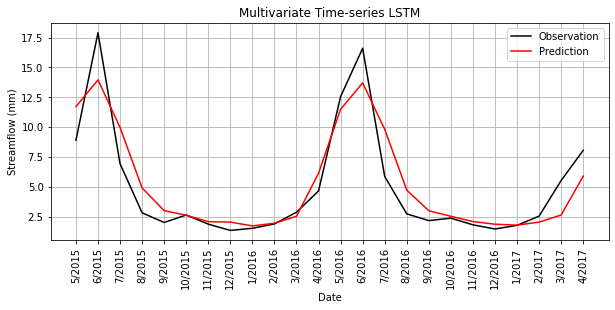

In [ ]:

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(real_values[29].values * b, color = 'black', label = 'Observation')
plt.plot(forecast_all[29] * b, color = 'red', label = 'Prediction')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['5/2015', "6/2015", "7/2015", "8/2015", "9/2015", "10/2015", "11/2015", "12/2015", "1/2016", "2/2016", "3/2016", "4/2016", "5/2016", "6/2016", "7/2016", "8/2016", "9/2016", "10/2016", "11/2016", "12/2016", "1/2017", "2/2017", "3/2017", "4/2017"], rotation=90)
plt.title('Multivariate Time-series LSTM')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.grid()
plt.legend()
plt.show()


# SARIMAX

In [ ]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:

# load dataset
series_temp = read_csv("/content/Step2_TEMPERATURES.csv")

series_temp = series_temp['Temperature']
series_temp = series_temp[0:1260+98]    


series_temp = series_temp.values



# load dataset
series_ppt = read_csv("/content/Step2_PRECIPITATIONS.csv")

series_ppt = series_ppt['Precipitation']
series_ppt = series_ppt[0:1260+98]

series_ppt = series_ppt.values



series = read_csv("/content/DATA.txt", sep="\t", header=None, names = ['dates', 'discharges'], thousands=',')




data1 = series[['discharges']]


data1_1 = np.log(data1)



data2 = pd.DataFrame()

data2['temperatures'] = series_temp
data2['precipitation'] = series_ppt


data2 = data2[['temperatures', 'precipitation']]




In [ ]:

import statsmodels.api as sm

def arimaTrain(train_data, exogs):

  model=sm.tsa.statespace.SARIMAX(endog=train_data, exog=exogs,order=(3, 0, 3), seasonal_order=(2,0,1,12)) 
  fitted = model.fit(disp=-1)

  return fitted


from sklearn.preprocessing import StandardScaler

forecast_all = []
real_all = []

for i in range(0, 50):

  x_train = data1[i:i+1260+24].values  
  add_variables_train = data2[i:i+1260+24].values
  st1 = StandardScaler()
  add_variables_train = st1.fit_transform(add_variables_train)   
  add_variables_train
  starting = 1260+24
  ending = 1260+24+24-1

  y_test = data1[i+1260+24:i+1260+24+24]
  real_all.append(y_test)
  add_variables_test = data2[i+1260+24:i+1260+24+24].values
  add_variables_test = st1.transform(add_variables_test) 
  add_variables_test

  fitted_value = arimaTrain(x_train, add_variables_train)
  forecast = fitted_value.predict(start=starting, end=ending, exog=add_variables_test, dynamic=True)
  forecast_all.append(forecast)




real_values = real_all


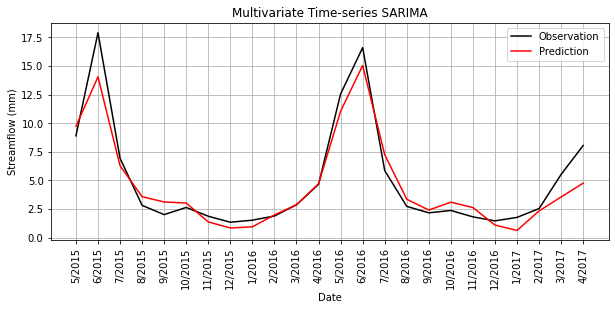

In [ ]:

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(real_values[29].values * b, color = 'black', label = 'Observation')
plt.plot(forecast_all[29] * b, color = 'red', label = 'Prediction')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['5/2015', "6/2015", "7/2015", "8/2015", "9/2015", "10/2015", "11/2015", "12/2015", "1/2016", "2/2016", "3/2016", "4/2016", "5/2016", "6/2016", "7/2016", "8/2016", "9/2016", "10/2016", "11/2016", "12/2016", "1/2017", "2/2017", "3/2017", "4/2017"], rotation=90)
plt.title('Multivariate Time-series SARIMA')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.grid()
plt.legend()
plt.show()


# PROPHET

In [ ]:
# to remove warnings in output
import logging
logging.getLogger("prophet").propagate=False

In [ ]:

# load dataset
series_temp = read_csv("/content/Step2_TEMPERATURES.csv")

series_temp = series_temp['Temperature']
series_temp = series_temp[0:1190+168]     


series_temp = series_temp.values


# load dataset
series_ppt = read_csv("/content/Step2_PRECIPITATIONS.csv")

series_ppt = series_ppt['Precipitation']
series_ppt = series_ppt[0:1190+168]

series_ppt = series_ppt.values



series = read_csv("/content/DATA2P.txt", sep="\t", header=None, names = ['ds', 'y'], thousands=',')



df = series
df = df[['ds', 'y']]

df_test = df['y']



df['temperature'] = series_temp
df['precipitation'] = series_ppt


In [ ]:

forecast_all = []
real_all = []

for i in range(0, 120):

    x_train = df[i:i + 1190 + 24]

    y_test = df_test[i + 1190 + 24:i + 1190 + 24 + 24]
    real_all.append(y_test)


    m_new = Prophet(yearly_seasonality=True,
                    seasonality_mode='multiplicative',
                    changepoint_prior_scale=0.1,
                    n_changepoints=100,
                    interval_width=0.95)

    m_new.add_regressor('temperature')
    m_new.add_regressor('precipitation')

    m_new.fit(x_train)
    future = m_new.make_future_dataframe(periods=24, freq='M')
    future = x_train[['ds', 'temperature', 'precipitation']]

    forecast = m_new.predict(future)
    yhat_test = forecast['yhat'][-24:]
    yhat_test = np.array(yhat_test)
    forecast_all.append(yhat_test)



real_values = real_all



DEBUG:cmdstanpy:input tempfile: /tmp/tmp8n68k3ez/zk4qjth8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8n68k3ez/p5k48noi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19577', 'data', 'file=/tmp/tmp8n68k3ez/zk4qjth8.json', 'init=/tmp/tmp8n68k3ez/p5k48noi.json', 'output', 'file=/tmp/tmpf5vqwor6/prophet_model-20220911184728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8n68k3ez/6ktapfbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8n68k3ez/yq2uso17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

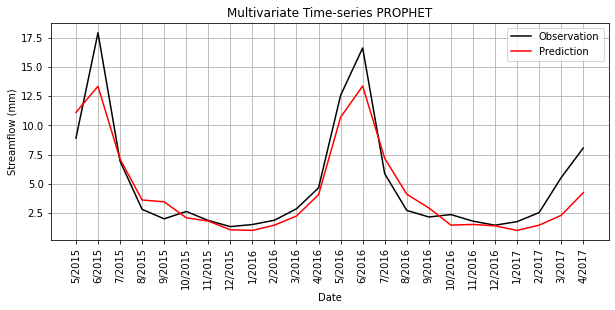

In [ ]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(real_values[99].values * b, color = 'black', label = 'Observation')
plt.plot(forecast_all[99] * b, color = 'red', label = 'Prediction')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['5/2015', "6/2015", "7/2015", "8/2015", "9/2015", "10/2015", "11/2015", "12/2015", "1/2016", "2/2016", "3/2016", "4/2016", "5/2016", "6/2016", "7/2016", "8/2016", "9/2016", "10/2016", "11/2016", "12/2016", "1/2017", "2/2017", "3/2017", "4/2017"], rotation=90)
plt.title('Multivariate Time-series PROPHET')
plt.xlabel('Date')
plt.ylabel('Streamflow (mm)')
plt.grid()
plt.legend()
plt.show()